# **Model Training**

## Objectives

* Create the Machine Learning model to predict healty and powdery mildew cherry leaves to answer business requirement 2.

## Inputs

* inputs/mildew_detection_in_cherry_leaves/cherry-leaves/test.
* inputs/mildew_detection_in_cherry_leaves/cherry-leaves/train.
* inputs/mildew_detection_in_cherry_leaves/cherry-leaves/validation.

## Outputs

* Resize images.
* Image aumentation.
* Images distribution plot in train, validation, and test set.
* Create Machine learning model and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation
* Prediction of the random image file.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Set working directory

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves'

---

# Set input directories

Set train, validation and test paths.

In [5]:
my_data_dir = 'inputs/mildew_detection_in_cherry_leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

---

# Set output directory

Create Output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Resize Images

To avoid having a file bigger than 100mb to push in github, we are going to recize the all images from 256x256 to 100x100.

First we install scikit-image to use the resize function

In [8]:
%pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


Create loop trough the files and plot the new standard size

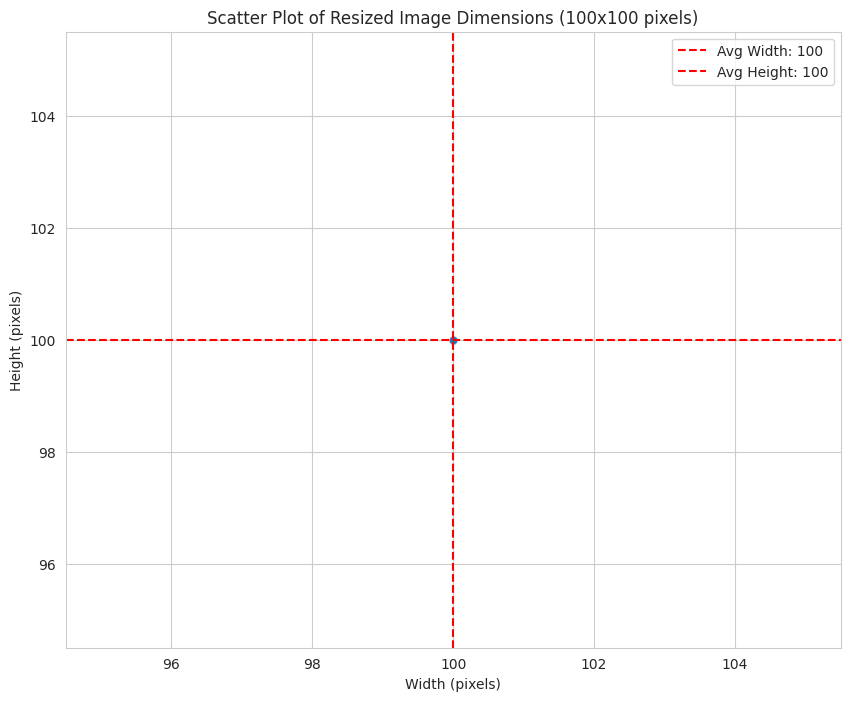

Resized Image Width: 100 pixels
Resized Image Height: 100 pixels


In [9]:
from skimage.transform import resize

# Create a dictionaty with all direcories
datasets = {
    'train': train_path,
    'test': test_path,
    'validation': val_path
}

# New size parameters
new_height, new_width = 100, 100

# New list of dimentions
dim1, dim2 = [], []

# Loop through each dataset to change the size
for dataset_name, dataset_path in datasets.items():
    # Loop through the labels
    labels = ['healthy', 'powdery_mildew']
    for label in labels:
        label_dir = os.path.join(dataset_path, label)
        for image_filename in os.listdir(label_dir):
            # Read the image
            img = imread(os.path.join(label_dir, image_filename))
            
            # Resize the image to 100x100 pixels
            img_resized = resize(img, (new_height, new_width), anti_aliasing=True)
            
            # Store the new dimensions (which will always be 100x100)
            d1, d2, colors = img_resized.shape
            dim1.append(d1)  # image height
            dim2.append(d2)  # image width

# Create scatterplot of resized image dimensions
sns.set_style("whitegrid")
fig, axes = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=dim1, y=dim2, alpha=0.2)

# Set axis labels
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")

# Compute and plot mean width and height lines
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--', label=f'Avg Width: {dim1_mean}')
axes.axhline(y=dim2_mean, color='r', linestyle='--', label=f'Avg Height: {dim2_mean}')
plt.legend()

# Show the plot
plt.title("Scatter Plot of Resized Image Dimensions (100x100 pixels)")
plt.show()

# Print the average dimensions (should always be 100x100)
print(f"Resized Image Width: {dim1_mean} pixels")
print(f"Resized Image Height: {dim2_mean} pixels")

New size

In [10]:
image_average_size = (dim1_mean, dim2_mean, 3)
image_average_size

(100, 100, 3)

---

# Count number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




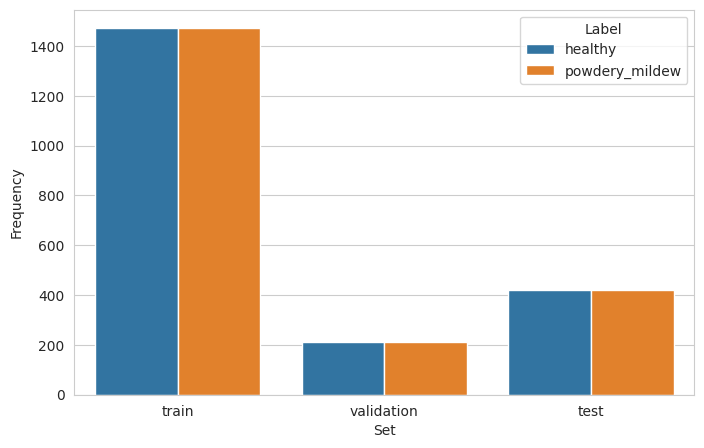

In [11]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

We selected to use a convalutional neural network to create our model. Since the amount of images is to small to train the model a data augmentaion is going to be done to increase the dataset

---

# Image Augmentation

---

## Set parameters to generate new images 

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=25,
                                          width_shift_range=0.20,
                                          height_shift_range=0.1,
                                          shear_range=0.1,
                                          zoom_range=0.25,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


### Augment training image dataset

In [13]:
batch_size = 20  
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_average_size[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [14]:
batch_size = 20  
val_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                     target_size=image_average_size[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

val_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [15]:
batch_size = 20  
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                     target_size=image_average_size[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training images

(20, 100, 100, 3)


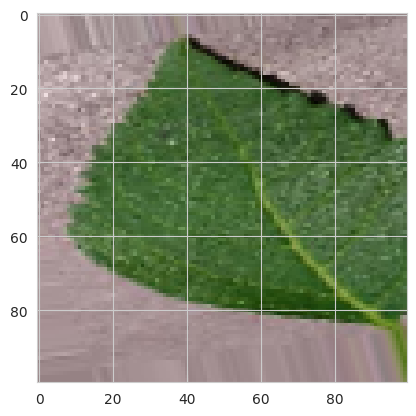

(20, 100, 100, 3)


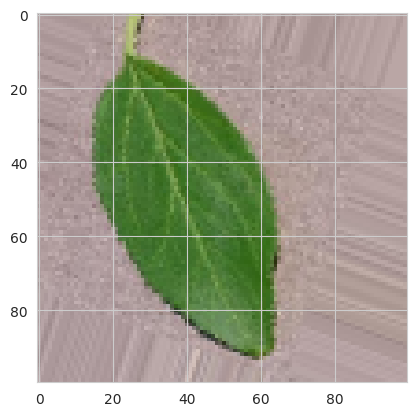

(20, 100, 100, 3)


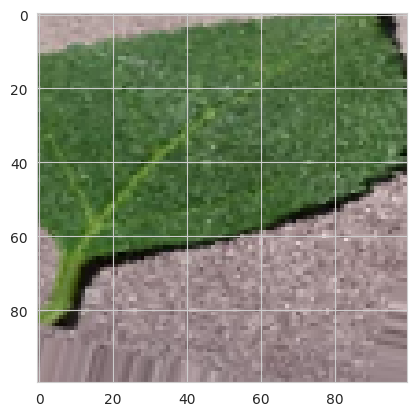

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape) # new shape with (20, 100, 100, 3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation images

(20, 100, 100, 3)


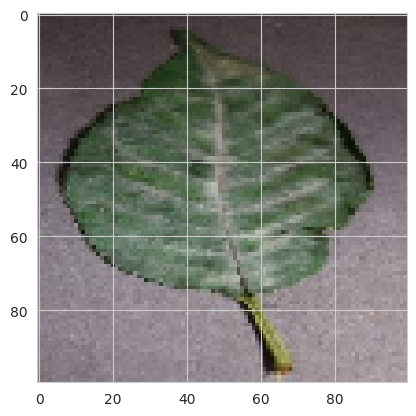

(20, 100, 100, 3)


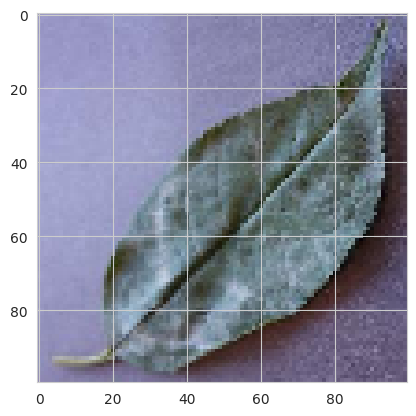

(20, 100, 100, 3)


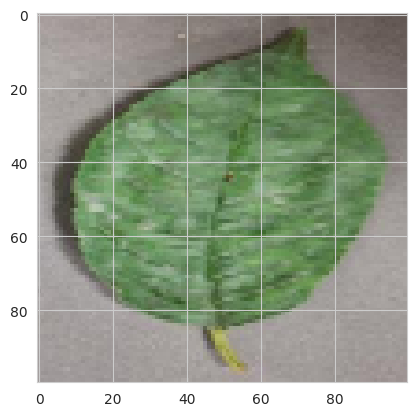

In [17]:
for _ in range(3):
    img, label = val_set.next()
    print(img.shape) # new shape with (20, 100, 100, 3)
    plt.imshow(img[0])
    plt.show()

### Plot augmented test images

(20, 100, 100, 3)


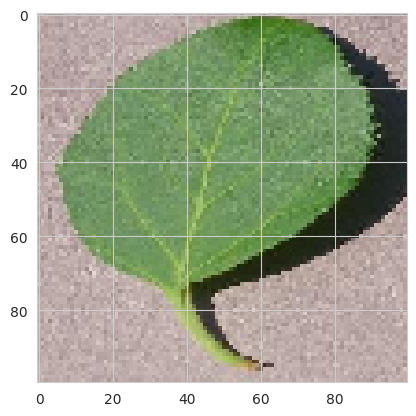

(20, 100, 100, 3)


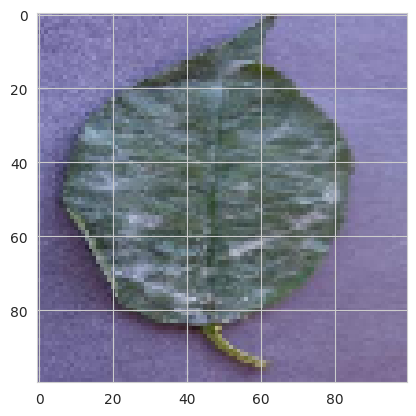

(20, 100, 100, 3)


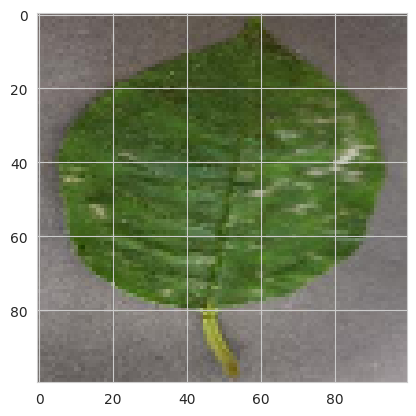

In [18]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape) # new shape with (20, 100, 100, 3)
    plt.imshow(img[0])
    plt.show()

### Save data

In [19]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Machine learning Model

---

## Import Libraries

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


## Model Architecture

In [33]:
def create_tf_model(input_shape=(100, 100, 3)):
    # Initialize Sequential model
    model = Sequential()

    # First Convolutional Layer + MaxPooling
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer + MaxPooling
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer + MaxPooling
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the feature maps to feed into the dense layers
    model.add(Flatten())

    # Fully Connected Layer (Dense Layer) with 128 neurons and ReLU activation
    model.add(Dense(128, activation='relu'))

    # Dropout to prevent overfitting
    model.add(Dropout(0.5))

    # Output Layer with Sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary crossentropy loss, Adam optimizer, and accuracy as the metric
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Model Summary

In [34]:
model = create_tf_model() 
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)            

## Early Stop

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Train the model

In [35]:
# Train the model
model.fit(train_set,  
          epochs=25,  
          steps_per_epoch=len(train_set.classes) // batch_size, 
          validation_data=val_set,  
          callbacks=[early_stop],  
          verbose=1  
          )


Epoch 1/25
147/147 [==============================] - 27s 181ms/step - loss: 0.3515 - accuracy: 0.8239 - val_loss: 0.0475 - val_accuracy: 0.9833
Epoch 2/25
147/147 [==============================] - 23s 158ms/step - loss: 0.0888 - accuracy: 0.9723 - val_loss: 0.0633 - val_accuracy: 0.9786
Epoch 3/25
147/147 [==============================] - 21s 141ms/step - loss: 0.0536 - accuracy: 0.9826 - val_loss: 0.0198 - val_accuracy: 0.9952
Epoch 4/25
147/147 [==============================] - 21s 141ms/step - loss: 0.0422 - accuracy: 0.9887 - val_loss: 0.0991 - val_accuracy: 0.9619
Epoch 5/25
147/147 [==============================] - 20s 139ms/step - loss: 0.0326 - accuracy: 0.9880 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 6/25
147/147 [==============================] - 20s 139ms/step - loss: 0.0378 - accuracy: 0.9870 - val_loss: 4.3179e-04 - val_accuracy: 1.0000
Epoch 7/25
147/147 [==============================] - 28s 191ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.0011 - va

## Save Model

In [36]:

model.save(f"outputs/{version}/mildew_detection_model.h5")


--- 


# Model Performance

---

## Model Learning curve

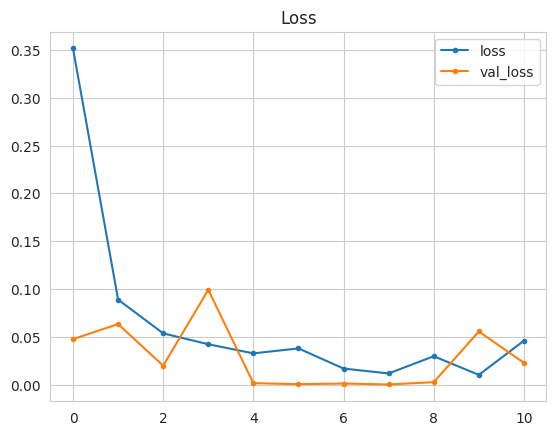

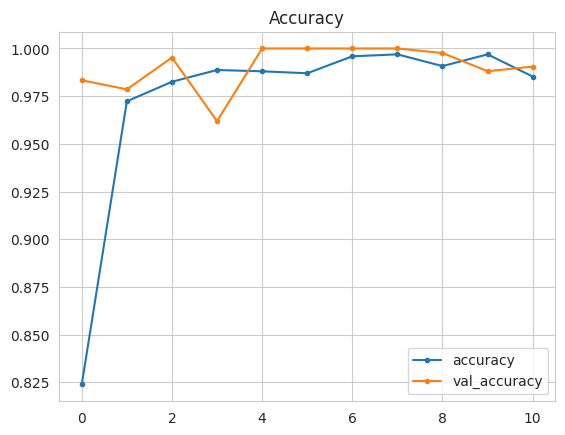

In [37]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

The model seems to have learned properlly but with a few spikes indicating some minor overfitting or noisy validation data. To confirm if its needed to apply hyperparameters adjustment first we evaluate the accuracy level

In [38]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 1s 33ms/step - loss: 0.0510 - accuracy: 0.9917


Since we have loss of 0.0168 meaning that the model's prediction are qute close to the true vale, and a accuracy of 99.11% surpassing the business agreement of 97%. Because of this results no further techniques will be applied

## Save results in a output directory

In [39]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation_results.pkl")

['outputs/v1/evaluation_results.pkl']

## Make a prediction

Load random image

Image shape: (100, 100), Image mode: RGB


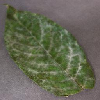

In [40]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # select Powdery Mildew leave

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_average_size, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert Image to array nad prepare prediction

In [41]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 100, 100, 3)


Predic class probabilities

In [42]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.99999297
powdery_mildew


## Add gitignore files

gitignore files

In [54]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
inputs/mildew_detection_in_cherry_leaves/cherry-leaves/train/
inputs/mildew_detection_in_cherry_leaves/cherry-leaves/test/
